In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
  !pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 54.3 MB/s 
     |████████████████████████████████| 182 kB 89.1 MB/s 


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/Final_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/testset.csv')

In [ ]:
data.head()

,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,Ex Wife Threatening SuicideRecently I left my ...,0,0
1,1,Am I weird I don t get affected by compliments...,1,1
2,2,Finally is almost over So I can never hear ...,1,0
3,3,i need helpjust help me im crying so hard,0,0
4,4,I m so lostHello my name is Adam and I ve b...,0,0


In [ ]:
test.head()

,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,I ve pushed everyone awayI moved away from my ...,0,0
1,1,Gonna go cook some ramen boys And I don t mean...,1,2
2,2,smilemy father today smiled at me but it looke...,0,0
3,3,I keep being told to be careful by people th...,0,0
4,4,Yoo anyone down to give me some advice or just...,1,0


In [ ]:
data = data.dropna()

In [ ]:
test = test.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.Suicidal_label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=data.Suicidal_label.values)

In [ ]:
data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

## Tokenization

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    list(test.Post.values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].Suicidal_label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].Suicidal_label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test.Suicidal_label.values)


## Creating Dataloaders

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
label_dict = {'suicide': 0, 'non-suicide': 1}

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                                   sampler=RandomSampler(dataset_train), 
                                   batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    losses = []
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        losses.append(loss.item())
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return losses, loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        # print(batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Data/suicidal_model_epoch_{epoch}.model'')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    losses_val, val_loss, predictions_val, true_vals_val = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2318 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.08212252547800226
Validation loss: 0.06357954274744881
F1 Score (Weighted): 0.9817477179230675


Epoch 2:   0%|          | 0/2318 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.04302017743032501
Validation loss: 0.0693048738923879
F1 Score (Weighted): 0.9830722187876433


Epoch 3:   0%|          | 0/2318 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.02569332639254977
Validation loss: 0.07936919812877787
F1 Score (Weighted): 0.9825214511370793


In [ ]:
losses_test, test_loss, predictions_test, true_vals_test= evaluate(dataloader_test)

### Validation Performance metrics

In [ ]:
accuracy_per_class(predictions_val, true_vals_val)

Class: suicide
Accuracy: 16521/17029

Class: non-suicide
Accuracy: 16447/17006



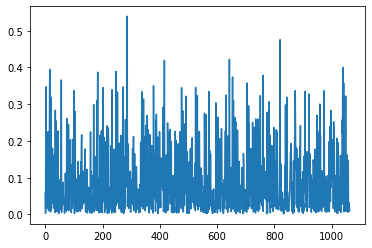

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses_val)

In [ ]:
preds_val = np.argmax(predictions_val, axis=1).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix
cm_val = confusion_matrix(true_vals_val,preds_val)

In [ ]:
cm_val

array([[16521,   508],
       [  559, 16447]])

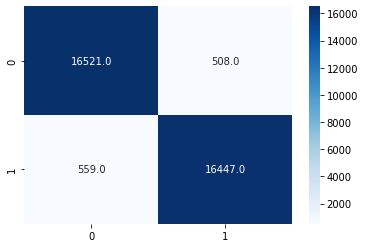

In [ ]:
sns.heatmap(cm_val.astype(int),annot=True, cmap='Blues',fmt=".1f")

### Test Performance metrics

In [ ]:
accuracy_per_class(predictions_test, true_vals_test)

Class: suicide
Accuracy: 3013/3117

Class: non-suicide
Accuracy: 3146/3253



In [ ]:
test_f1 = f1_score_func(predictions_test, true_vals_test)
print('Test F1 Score is:', test_f1)

Test F1 Score is: 0.9668763070182195


In [ ]:
print("Average Test Loss:", test_loss)

Average Test Loss: 0.09717365493183024


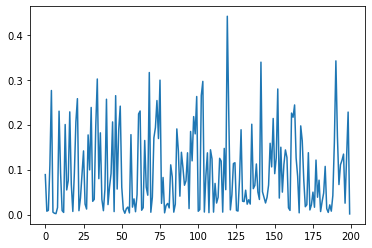

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses_test)

In [ ]:
preds_test = np.argmax(predictions_test, axis=1).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(true_vals_test,preds_test)

In [ ]:
cm_test

array([[3013,  104],
       [ 107, 3146]])

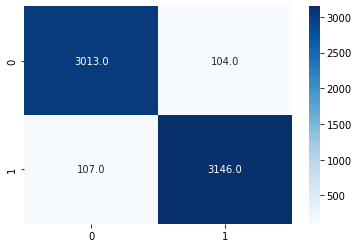

In [ ]:
sns.heatmap(cm_test.astype(int),annot=True, cmap='Blues',fmt=".1f")

## Hugging Face Pre-Trained

In [ ]:
def evaluate_hf(dataloader_val):

    model_hf.eval()
    losses = []
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model_hf(**inputs)
            
        loss = outputs[0]
        losses.append(loss.item())
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return losses, loss_val_avg, predictions, true_vals

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gooohjy/suicidal-bert')

model_hf = AutoModelForSequenceClassification.from_pretrained('gooohjy/suicidal-bert')


Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
model_hf = model_hf.to(device)


In [ ]:
loss_hf, val_loss_hf, predictions_hf, true_vals_hf= evaluate_hf(dataloader_validation)

In [ ]:
accuracy_per_class(predictions_hf, true_vals_hf)

Class: non-suicide
Accuracy: 16853/17405

Class: suicide
Accuracy: 16994/17406



In [ ]:
val_f1_hf = f1_score_func(predictions_hf, true_vals_hf)
print('Validation F1 Score is:', val_f1_hf)

Validation F1 Score is: 0.9723071528089714


In [ ]:
print("Average Validation Loss:", val_loss_hf)

Average Validation Loss: 0.11929131009969751


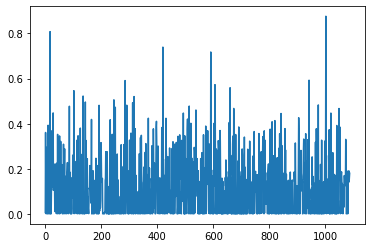

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_hf)

In [ ]:
from sklearn.metrics import confusion_matrix
preds_hf = np.argmax(predictions_hf, axis=1).flatten()
cm = confusion_matrix(true_vals_hf, preds_hf)
cm

array([[16853,   552],
       [  412, 16994]])

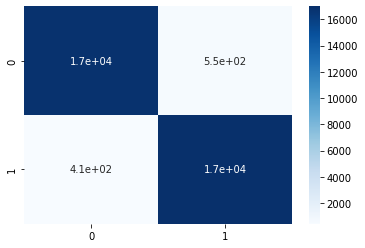

In [ ]:
sns.heatmap(cm.astype(int),annot=True, cmap='Blues')


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gooohjy/suicidal-bert')

model_hf = AutoModelForSequenceClassification.from_pretrained('gooohjy/suicidal-bert')


Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

1

In [ ]:
tokens = tokenizer.encode('I feel very lonely and sad', return_tensors='pt')
result_hf = model_hf(tokens)
result_hf.logits
int(torch.argmax(result.logits))+1

1